# Time series predictions notebook

In this notebook we will see can forecast bitcoin prices such that we can adapt uur positions, we will rely on time series to accomplish this task. We will check here: <br>
    1. Price prediction with a LSTM <br>
    2. Observe the effect of trends of the price movements

In [71]:
import json
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline
import yfinance as yf
import fbprophet
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')


# LSTM 

In [3]:
#Load data
eth_Ticker = yf.Ticker("ETH-USD")
eth_data = eth_Ticker.history(period="max").reset_index()

#Keep relevant data to avoid noisy signals 
eth_data = eth_data[(eth_data["Date"] >= "2019-06-01")]

target_col = "Close"
eth_data = eth_data.set_index("Date")

#drop not used data
eth_data = eth_data.reset_index().drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'],axis=1).set_index("Date")

In [5]:
#split data until the point in time we want to train our model on, the rest on the data will be used for testing
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [24]:
train, test = train_test_split(eth_data, test_size=0.2)

In [25]:
def observe_data(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

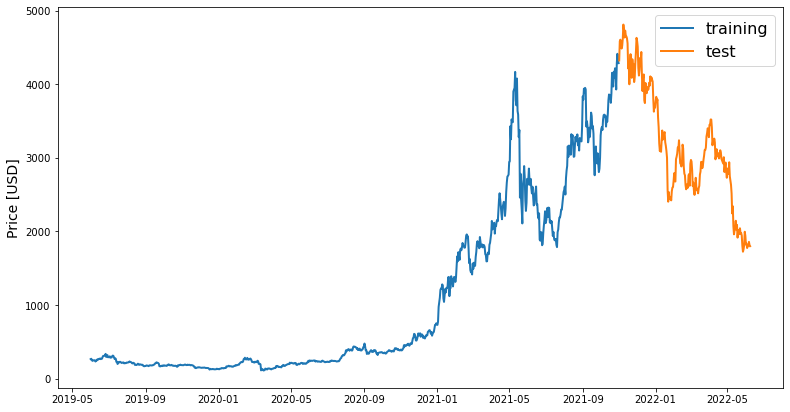

In [26]:
observe_data(train[target_col], test[target_col], 'training', 'test', title='')


In [37]:
#normalized stats based on first element in time
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

#normalized stats based on min max of time windows
def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [64]:
#rolling window data
def extract_window_data(df, window_len=5, normalize=normalise_zero_base):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        tmp = normalize(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [48]:
def prepare_data(df, target_col, window_len=10, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, normalise_zero_base)
    X_test = extract_window_data(test_data, window_len, normalise_zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    
    #if zero_base:
    y_train = y_train / train_data[target_col][:-window_len].values - 1
    y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [49]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [50]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [65]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    eth_data, target_col, window_len=window_len, test_size=test_size)

In [66]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [67]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
28/28 [==============================] - 5s 9ms/step - loss: 0.0084
Epoch 2/20
28/28 [==============================] - 0s 9ms/step - loss: 0.0053
Epoch 3/20
28/28 [==============================] - 0s 10ms/step - loss: 0.0046
Epoch 4/20
28/28 [==============================] - 0s 10ms/step - loss: 0.0044
Epoch 5/20
28/28 [==============================] - 0s 10ms/step - loss: 0.0038
Epoch 6/20
28/28 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 7/20
28/28 [==============================] - 0s 10ms/step - loss: 0.0033
Epoch 8/20
28/28 [==============================] - 0s 10ms/step - loss: 0.0031
Epoch 9/20
28/28 [==============================] - 0s 10ms/step - loss: 0.0030
Epoch 10/20
28/28 [==============================] - 0s 10ms/step - loss: 0.0030
Epoch 11/20
28/28 [==============================] - 0s 10ms/step - loss: 0.0029
Epoch 12/20
28/28 [==============================] - 0s 10ms/step - loss: 0.0028
Epoch 13/20
28/28 [====================

In [69]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.03120426923703044

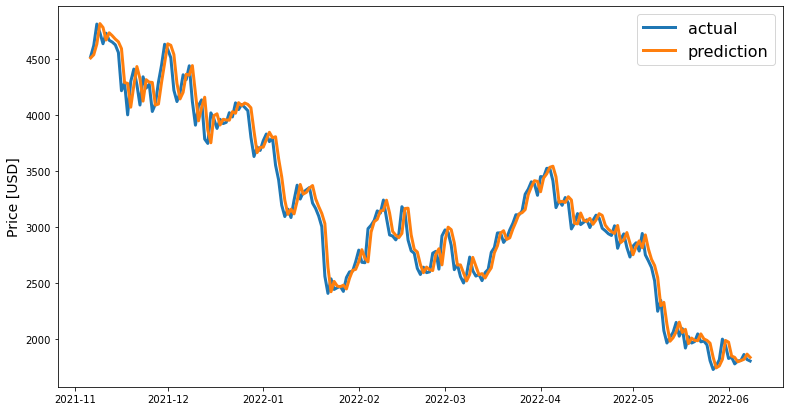

In [70]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
observe_data(targets, preds, 'actual', 'prediction', lw=3)

In [126]:
#means = np.array([])
for epoch in [40,60]:
    model = build_lstm_model(X_train, output_size=1, neurons=100, dropout=dropout, loss=loss,optimizer=optimizer)
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=16, verbose=1, shuffle=True)
    targets = test[target_col][window_len:]
    preds = model.predict(X_test).squeeze()
    means = np.append(means,mean_absolute_error(preds, y_test))
    

Epoch 1/40
55/55 [==============================] - 6s 8ms/step - loss: 0.0079
Epoch 2/40
55/55 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 3/40
55/55 [==============================] - 1s 9ms/step - loss: 0.0040
Epoch 4/40
55/55 [==============================] - 1s 10ms/step - loss: 0.0035
Epoch 5/40
55/55 [==============================] - 1s 9ms/step - loss: 0.0032
Epoch 6/40
55/55 [==============================] - 1s 10ms/step - loss: 0.0031
Epoch 7/40
55/55 [==============================] - 1s 10ms/step - loss: 0.0030
Epoch 8/40
55/55 [==============================] - 1s 10ms/step - loss: 0.0029
Epoch 9/40
55/55 [==============================] - 1s 10ms/step - loss: 0.0028
Epoch 10/40
55/55 [==============================] - 1s 11ms/step - loss: 0.0027
Epoch 11/40
55/55 [==============================] - 1s 12ms/step - loss: 0.0028
Epoch 12/40
55/55 [==============================] - 1s 13ms/step - loss: 0.0026
Epoch 13/40
55/55 [======================

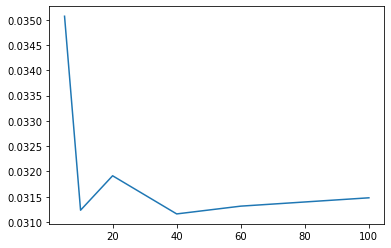

In [130]:
plt.plot([5,10,20,40,60,100],means)

In [128]:
means

array([0.03507076, 0.03123301, 0.03191431, 0.03147825, 0.03115938,
       0.03131314])

In [129]:
means = [0.03507076, 0.03123301, 0.03191431,0.03115938,
       0.03131314, 0.03147825]

# Prophet

In [72]:
#Load data
eth_Ticker = yf.Ticker("BNB-USD")
eth_data = eth_Ticker.history(period="max").reset_index()

#Delete not used data
eth_data = eth_data.reset_index().drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'],axis=1).set_index("Date")

In [73]:
#instantiate Prophet model
m = Prophet()

In [74]:
#set prophet seasonality
m.add_seasonality(name="daily",period=30.5,fourier_order=5)

In [75]:
train, test = train_test_split(eth_data, test_size=0.2)

In [76]:
eth_data = eth_data.reset_index()
eth_data = eth_data.drop(['index'],axis=1)
#label data according to prophet specifications
data = eth_data.rename(columns={"Date":"ds","Close":"y"})

In [77]:
m.fit(data)

INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


In [78]:
#set future interval
future_dates = m.make_future_dataframe(periods=15)

In [79]:
#predict
prediction = m.predict(future_dates)

## Predictions

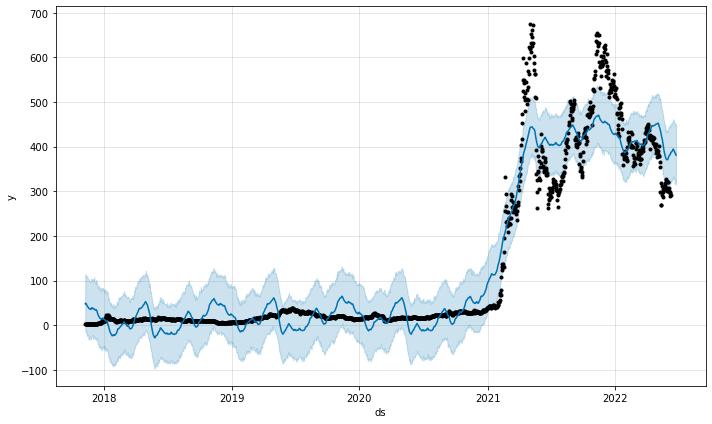

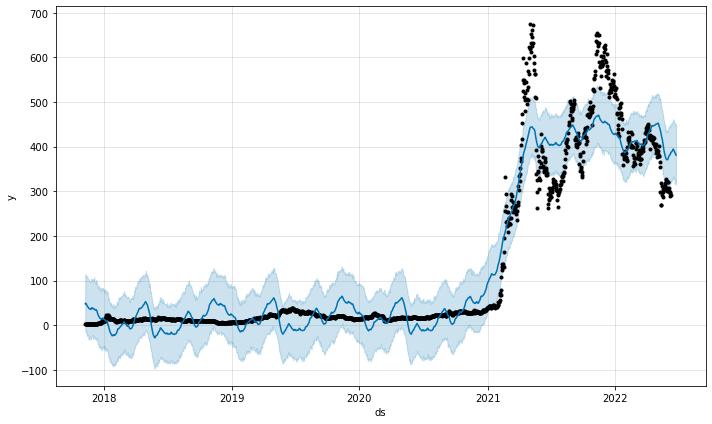

In [80]:
m.plot(prediction)

## Trends

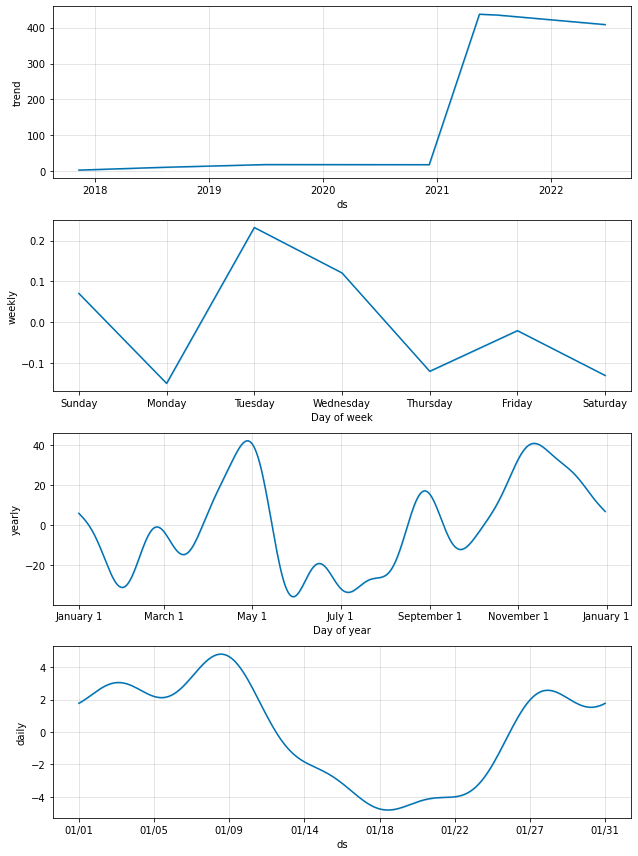

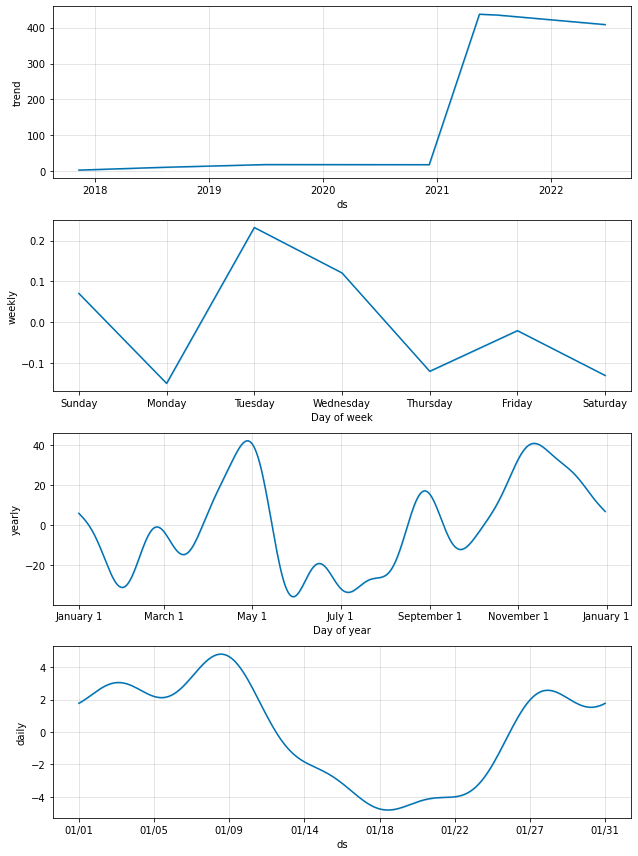

In [81]:
m.plot_components(prediction)

#### According to prophet from 2021 up 450 dollars of the price of eth are due to the yearly trend, also we observe that each year there is a decrease in the price around may. This is valuable information as each year we will able to decorelate price movements from the actual trend that prices follow.

In [82]:
test=test["Close"]

<AxesSubplot:xlabel='Date'>

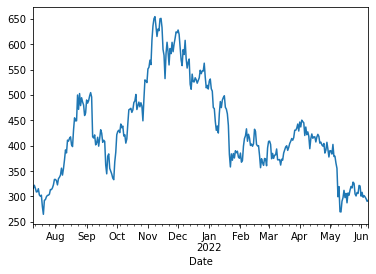

In [83]:
test.plot()

In [84]:
from fbprophet.plot import add_changepoints_to_plot

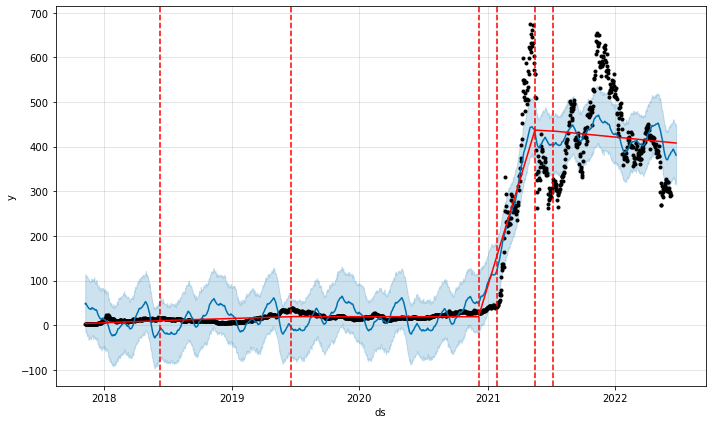

In [85]:
fig =m.plot(prediction)
c= add_changepoints_to_plot(fig.gca(),m,prediction)

Prophet defines somes points in time where is consider major time trends change from them, here we can see that 2021 has been a decisive year for the evolution of the price of eth